In [1395]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST MT 2016
---

## VEST Documentation

### Election Results

#### Sources
Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

#### Sources
Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program. 

The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley.

### Processing
Precinct splits in Lake County were reversed based on the 2016 precinct shapefile from the county. The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

### Candidates

G16PRERTRU - Donald Trump (Republican Party)  
G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
G16PREGSTE - Jill Stein (Green Party)  
G16PREOFUE - "Rocky" Roque de la Fuente (American Delta)  
  
G16HALRZIN - Ryan Zinke (Republican Party)  
G16HALDJUN - Denise Juneau (Democratic Party)  
G16HALLBRE - Rick Breckenridge (Libertarian Party)  
  
G16GOVRGIA - Greg Gianforte (Republican Party)  
G16GOVDBUL - Steve Bullock (Democratic Party)  
G16GOVLDUN - Ted Dunlap (Libertarian Party)  
  
G16ATGRFOX - Tim Fox (Republican Party)  
G16ATGDJEN - Larry Jent (Democratic Party)  
  
G16SOSRSTA - Corey Stapleton (Republican Party)  
G16SOSDLIN - Monica Lindeen (Democratic Party)  
G16SOSLROO - Roger Roots (Libertarian Party)  
  
G16AUDRROS - Matt Rosendale (Republican Party)  
G16AUDDLAS - Jesse Laslovich (Democratic Party)  
  
G16SPIRARN - Elsie Arntzen (Republican Party)  
G16SPIDROM - Melissa Romano (Democratic Party)  

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [1396]:
vest_mt_16 = gp.read_file("./raw-from-source/VEST/mt_2016/mt_2016.shp")

In [1397]:
vest_mt_16.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

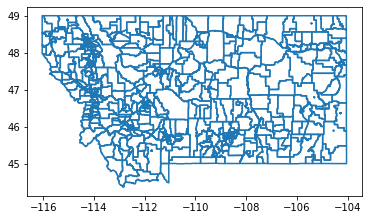

In [1398]:
vest_mt_16.boundary.plot()

In [1399]:
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for MT

In [1400]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
mt_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Created `2016-General-Results-by-Precinct.csv` from `2016-General-Results-by-Precinct.xlsx` by opening in Excel and saving as a csv. No file modifications were made. 

In [1401]:
#Load in clean SOS file
elections_2016 = pd.read_csv("./raw-from-source/MT_SOS/2016-General-Results-by-Precinct.csv")

In [1402]:
elections_2016.shape

(31197, 21)

In [1403]:
elections_2016.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Beaverhead,PRECINCT 01,PRESIDENT AND VICE PRESIDENT,DEM,175,...,NaN,NaN,NaN,NaN,NaN
1,Beaverhead,PRECINCT 12,PRESIDENT AND VICE PRESIDENT,DEM,157,...,NaN,NaN,NaN,NaN,NaN
2,Beaverhead,PRECINCT 14,PRESIDENT AND VICE PRESIDENT,DEM,125,...,NaN,NaN,NaN,NaN,NaN
3,Beaverhead,PRECINCT 17,PRESIDENT AND VICE PRESIDENT,DEM,18,...,NaN,NaN,NaN,NaN,NaN
4,Beaverhead,PRECINCT 19,PRESIDENT AND VICE PRESIDENT,DEM,14,...,NaN,NaN,NaN,NaN,NaN


### Prepare to Pivot Election Results

In [1404]:
#Filter down to the offices we need
office_list = ['PRESIDENT AND VICE PRESIDENT','UNITED STATES REPRESENTATIVE','GOVERNOR & LT. GOVERNOR',
               'ATTORNEY GENERAL','SECRETARY OF STATE','STATE AUDITOR',
               'STATE SUPERINTENDENT OF PUBLIC INSTRUCTION']
elections_2016 = elections_2016[elections_2016["RaceName"].isin(office_list)]

In [1405]:
elections_2016["NameOnBallot"].unique()

array(['HILLARY CLINTON AND TIM KAINE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG',
       'GARY JOHNSON AND BILL WELD', 'JILL STEIN AND AJAMU BARAKA',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'RICK BRECKENRIDGE',
       'DENISE JUNEAU', 'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER',
       'GREG GIANFORTE AND LESLEY ROBINSON', 'MONICA J. LINDEEN',
       'ROGER ROOTS', 'COREY STAPLETON', 'TIM FOX', 'LARRY JENT',
       'JESSE LASLOVICH', 'MATT ROSENDALE', 'ELSIE ARNTZEN',
       'MELISSA ROMANO'], dtype=object)

In [1406]:
# Change column names to match the county fips dict
elections_2016.loc[elections_2016['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Map to the correct FIP
elections_2016["county"]=elections_2016["CountyName"].map(mt_fips_dict).fillna(elections_2016["CountyName"])

#Print out the FIPS to make sure they all are in the correct format
elections_2016["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [1407]:
print(elections_2016["CountyName"].nunique())
print(len(mt_fips_dict))

56
56


In [1408]:
#Clean up the precinct column by striping the white space
elections_2016["PrecinctName"]=elections_2016["PrecinctName"].str.strip()

#Create a column to pivot one by concatenating the FIPS with the precinct
elections_2016["pivot_col"]=elections_2016["county"]+elections_2016["PrecinctName"]

### Pivot Election Results

In [1409]:
#Run the pivot
pivoted_2016 = pd.pivot_table(elections_2016,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill NA values w/ 0
pivoted_2016 = pivoted_2016.fillna(0)

#Clean the columns
pivoted_2016.reset_index(drop=False,inplace=True)
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)

In [1410]:
#Print the df to get a sense for it
pivoted_2016.head()

NameOnBallot,,COREY STAPLETON,DENISE JUNEAU,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,...,ROGER ROOTS,RYAN ZINKE,STEVE BULLOCK AND MIKE COONEY,TED DUNLAP AND RON VANDEVENDER,TIM FOX
0,001PRECINCT 01,229,205,203,196,...,23,230,267,15,275
1,001PRECINCT 02,540,178,551,511,...,32,546,249,23,600
2,001PRECINCT 03,524,186,507,469,...,18,532,252,15,587
3,001PRECINCT 04,123,41,131,121,...,2,128,60,4,143
4,001PRECINCT 05,100,16,99,91,...,3,100,17,2,105


In [1411]:
pivoted_2016.columns

Index(['', 'COREY STAPLETON', 'DENISE JUNEAU',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'ELSIE ARNTZEN',
       'GARY JOHNSON AND BILL WELD', 'GREG GIANFORTE AND LESLEY ROBINSON',
       'HILLARY CLINTON AND TIM KAINE', 'JESSE LASLOVICH',
       'JILL STEIN AND AJAMU BARAKA', 'LARRY JENT', 'MATT ROSENDALE',
       'MELISSA ROMANO', 'MONICA J. LINDEEN', 'RICK BRECKENRIDGE',
       'ROCKY ROQUE DE LA FUENTE AND MICHAEL STEINBERG', 'ROGER ROOTS',
       'RYAN ZINKE', 'STEVE BULLOCK AND MIKE COONEY',
       'TED DUNLAP AND RON VANDEVENDER', 'TIM FOX'],
      dtype='object', name='NameOnBallot')

In [1412]:
#Rename the columns
pivoted_2016.columns = ["join_col",'G16SOSRSTA', 'G16HALDJUN',
       'G16PRERTRU', 'G16SPIRARN',
       'G16PRELJOH', 'G16GOVRGIA',
       'G16PREDCLI', 'G16AUDDLAS',
       'G16PREGSTE', 'G16ATGDJEN', 'G16AUDRROS',
       'G16SPIDROM', 'G16SOSDLIN', 'G16HALLBRE',
       'G16PREOFUE', 'G16SOSLROO',
       'G16HALRZIN', 'G16GOVDBUL',
       'G16GOVLDUN', 'G16ATGRFOX']

In [1413]:
#Add in a column with the state, county and precinct name
pivoted_2016["STATEFP10"]="30"
pivoted_2016["COUNTYFP10"]=pivoted_2016["join_col"].str[0:3]
pivoted_2016["NAME"]=pivoted_2016["join_col"].str[3:]

In [1414]:
pivoted_2016.head()

,join_col,G16SOSRSTA,G16HALDJUN,G16PRERTRU,G16SPIRARN,...,G16GOVLDUN,G16ATGRFOX,STATEFP10,COUNTYFP10,NAME
0,001PRECINCT 01,229,205,203,196,...,15,275,30,001,PRECINCT 01
1,001PRECINCT 02,540,178,551,511,...,23,600,30,001,PRECINCT 02
2,001PRECINCT 03,524,186,507,469,...,15,587,30,001,PRECINCT 03
3,001PRECINCT 04,123,41,131,121,...,4,143,30,001,PRECINCT 04
4,001PRECINCT 05,100,16,99,91,...,2,105,30,001,PRECINCT 05


In [1415]:
#Take a look at VEST's file
vest_mt_16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

In [1416]:
#Reorder the election result df's columns to match VEST's
pivoted_2016 = pivoted_2016[['STATEFP10', 'COUNTYFP10', 'NAME','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM',"join_col"]]

#Create a join column in the VEST file
vest_mt_16["join_col"]=vest_mt_16['COUNTYFP10']+vest_mt_16['SOSPRECINC']

In [1417]:
pivoted_2016.shape

(686, 24)

## Compare Election Results Totals

### Compare Total Votes

In [1418]:
races = [x for x in vest_mt_16.columns if 'G16' in x]
races

['G16PRERTRU',
 'G16PREDCLI',
 'G16PRELJOH',
 'G16PREGSTE',
 'G16PREOFUE',
 'G16HALRZIN',
 'G16HALDJUN',
 'G16HALLBRE',
 'G16GOVRGIA',
 'G16GOVDBUL',
 'G16GOVLDUN',
 'G16ATGRFOX',
 'G16ATGDJEN',
 'G16SOSRSTA',
 'G16SOSDLIN',
 'G16SOSLROO',
 'G16AUDRROS',
 'G16AUDDLAS',
 'G16SPIRARN',
 'G16SPIDROM']

In [1419]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_16[i])
    sum_var_2 += np.sum(pivoted_2016[i])
print(sum_var_1)
print(sum_var_2)

3481824
3481824


### Compare Race Totals

In [1420]:
for race in races:
    diff_val = sum(vest_mt_16[race])-sum(pivoted_2016[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL - " + str(sum(vest_mt_16[race])))

G16PRERTRU: EQUAL - 279240
G16PREDCLI: EQUAL - 177709
G16PRELJOH: EQUAL - 28037
G16PREGSTE: EQUAL - 7970
G16PREOFUE: EQUAL - 1570
G16HALRZIN: EQUAL - 285358
G16HALDJUN: EQUAL - 205919
G16HALLBRE: EQUAL - 16554
G16GOVRGIA: EQUAL - 236115
G16GOVDBUL: EQUAL - 255933
G16GOVLDUN: EQUAL - 17312
G16ATGRFOX: EQUAL - 332766
G16ATGDJEN: EQUAL - 158970
G16SOSRSTA: EQUAL - 277473
G16SOSDLIN: EQUAL - 204861
G16SOSLROO: EQUAL - 17687
G16AUDRROS: EQUAL - 262045
G16AUDDLAS: EQUAL - 224925
G16SPIRARN: EQUAL - 253790
G16SPIDROM: EQUAL - 237590


### Compare County Totals

In [1421]:
diff_counties=[]
for i in races:
    diff = pivoted_2016.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_16.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(i + ' county totals: EQUAL')

G16PRERTRU county totals: EQUAL
G16PREDCLI county totals: EQUAL
G16PRELJOH county totals: EQUAL
G16PREGSTE county totals: EQUAL
G16PREOFUE county totals: EQUAL
G16HALRZIN county totals: EQUAL
G16HALDJUN county totals: EQUAL
G16HALLBRE county totals: EQUAL
G16GOVRGIA county totals: EQUAL
G16GOVDBUL county totals: EQUAL
G16GOVLDUN county totals: EQUAL
G16ATGRFOX county totals: EQUAL
G16ATGDJEN county totals: EQUAL
G16SOSRSTA county totals: EQUAL
G16SOSDLIN county totals: EQUAL
G16SOSLROO county totals: EQUAL
G16AUDRROS county totals: EQUAL
G16AUDDLAS county totals: EQUAL
G16SPIRARN county totals: EQUAL
G16SPIDROM county totals: EQUAL


### Check for Zero Vote Precincts in VEST

In [1422]:
vest_mt_16[vest_mt_16['G16PRERTRU'] == 0]

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,...,G16AUDDLAS,G16SPIRARN,G16SPIDROM,geometry,join_col
389,30,029,Flathead,NA,None,...,0,0,0,"POLYGON ((-113.79807 48.22350, -113.79620 48.2...",NaN
390,30,029,Flathead,NA,None,...,0,0,0,"POLYGON ((-113.79240 48.38270, -113.79256 48.3...",NaN
682,30,047,Lake,NA,None,...,0,0,0,"POLYGON ((-114.03396 47.95345, -114.03355 47.9...",NaN


In [1423]:
vest_mt_16['join_col'] = vest_mt_16['join_col'].str.upper()
pivoted_2016['join_col'] = pivoted_2016['join_col'].str.upper()

### Attempt to join the dataframes

In [1424]:
join_attempt_one = pd.merge(vest_mt_16,pivoted_2016,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          685
left_only       4
right_only      1
Name: _merge, dtype: int64


In [1425]:
join_attempt_one.columns

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY', 'NAME_x', 'SOSPRECINC',
       'G16PRERTRU_x', 'G16PREDCLI_x', 'G16PRELJOH_x', 'G16PREGSTE_x',
       'G16PREOFUE_x', 'G16HALRZIN_x', 'G16HALDJUN_x', 'G16HALLBRE_x',
       'G16GOVRGIA_x', 'G16GOVDBUL_x', 'G16GOVLDUN_x', 'G16ATGRFOX_x',
       'G16ATGDJEN_x', 'G16SOSRSTA_x', 'G16SOSDLIN_x', 'G16SOSLROO_x',
       'G16AUDRROS_x', 'G16AUDDLAS_x', 'G16SPIRARN_x', 'G16SPIDROM_x',
       'geometry', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'NAME_y',
       'G16PRERTRU_y', 'G16PREDCLI_y', 'G16PRELJOH_y', 'G16PREGSTE_y',
       'G16PREOFUE_y', 'G16HALRZIN_y', 'G16HALDJUN_y', 'G16HALLBRE_y',
       'G16GOVRGIA_y', 'G16GOVDBUL_y', 'G16GOVLDUN_y', 'G16ATGRFOX_y',
       'G16ATGDJEN_y', 'G16SOSRSTA_y', 'G16SOSDLIN_y', 'G16SOSLROO_y',
       'G16AUDRROS_y', 'G16AUDDLAS_y', 'G16SPIRARN_y', 'G16SPIDROM_y',
       '_merge'],
      dtype='object')

In [1426]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTY','NAME_x','NAME_y','join_col']]

,COUNTY,NAME_x,NAME_y,join_col
190,Cascade,P22B,NaN,013P22B
389,Flathead,NA,NaN,NaN
390,Flathead,NA,NaN,NaN
391,Lake,NA,NaN,NaN
689,NaN,NaN,P22B.,013P22B.


In [1427]:
source_vest_names_dict = {'013P22B.':'013P22B'}

#Use the dictionary to change the names
pivoted_2016["join_col"]=pivoted_2016["join_col"].map(source_vest_names_dict).fillna(pivoted_2016["join_col"])

### Join Attempt 2

In [1428]:
join_attempt_two = pd.merge(vest_mt_16,pivoted_2016,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          686
left_only       3
right_only      0
Name: _merge, dtype: int64


In [1429]:
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTY','NAME_x','NAME_y','join_col']]

,COUNTY,NAME_x,NAME_y,join_col
389,Flathead,NA,NaN,NaN
390,Flathead,NA,NaN,NaN
391,Lake,NA,NaN,NaN


Only the 3 zero vote precincts left. 

### Compare Precinct Votes

In [1430]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [1431]:
validater_row(join_attempt_two[join_attempt_two['_merge'] == 'both'].sort_values("join_col"),races)


There are  686  total rows
0  of these rows have election result differences
686  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


# Precinct Shapefile

## Load in the shapefiles

### Shp from SOS

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the shapefile from the SOS: https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7bdbd29997-21d8-4af1-9d87-5c5134775995%7d
Navigate to "Download Data", select "MontanaVotingPrecincts_shp.zip". 

Confirming whether this file is the same as the TIGER/Line file. 

In [1432]:
mt_shp = gp.read_file('./raw-from-source/MT_SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [1433]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,...,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,...,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [1434]:
print(mt_shp.shape)
vest_mt_16.shape

(666, 17)


(689, 27)

In [1435]:
mt_shp.crs

<Projected CRS: EPSG:32100>
Name: NAD83 / Montana
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Montana - counties of Beaverhead; Big Horn; Blaine; Broadwater; Carbon; Carter; Cascade; Chouteau; Custer; Daniels; Dawson; Deer Lodge; Fallon; Fergus; Flathead; Gallatin; Garfield; Glacier; Golden Valley; Granite; Hill; Jefferson; Judith Basin; Lake; Lewis and Clark; Liberty; Lincoln; Madison; McCone; Meagher; Mineral; Missoula; Musselshell; Park; Petroleum; Phillips; Pondera; Powder River; Powell; Prairie; Ravalli; Richland; Roosevelt; Rosebud; Sanders; Sheridan; Silver Bow; Stillwater; Sweet Grass; Teton; Toole; Treasure; Valley; Wheatland; Wibaux; Yellowstone.
- bounds: (-116.07, 44.35, -104.04, 49.01)
Coordinate Operation:
- name: SPCS83 Montana zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1436]:
vest_mt_16 = vest_mt_16.to_crs(epsg=32100)

<AxesSubplot:>

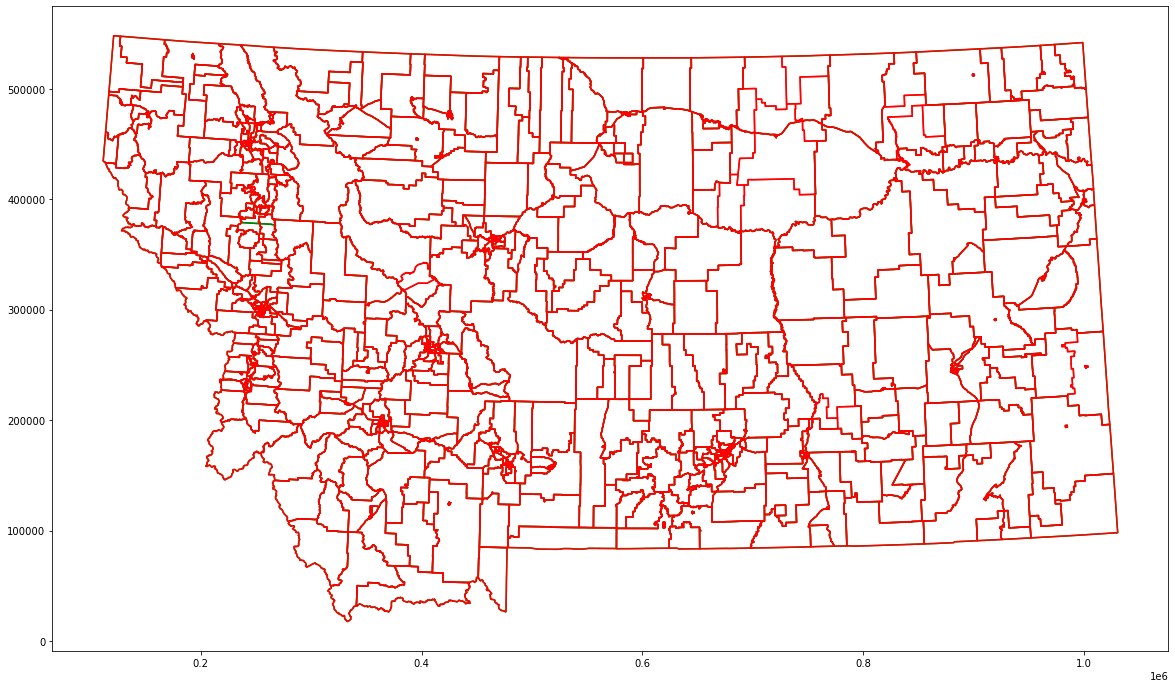

In [1437]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_16.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [1438]:
#Add a join column to the source shapefile
mt_shp["join_col"]=mt_shp['COUNTYFP10']+mt_shp['NAME']
mt_shp

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,...,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,...,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52...",051#1 Precinct - West
1,000001,1-HERON-HD13,13,7,HERON COMMUNITY CENTER,...,45,89108.059261,2.808293e+08,"POLYGON ((114102.250 461041.840, 114155.020 46...",0891-HERON-HD13
2,000001,1 WESTBY,34,17,WESTBY COMMUNITY HALL,...,46,152033.377796,7.430864e+08,"POLYGON ((998562.006 541713.323, 998580.694 54...",0911 WESTBY
3,000001,COLUMBUS PRECINCT 1,57,29,STILLWATER PAVILLION,...,48,210565.225728,9.073550e+08,"POLYGON ((616112.063 176124.484, 616516.128 17...",095COLUMBUS PRECINCT 1
4,000001,FORT BENTON 1,27,14,FORT BENTON ELEMENTARY,...,08,109711.564255,4.525434e+08,"POLYGON ((518671.300 403468.700, 518742.000 40...",015FORT BENTON 1
...,...,...,...,...,...,...,...,...,...,...,...
661,091RsE,RATTLSNK 91E,91,46,RATTLESNAKE SCHOOL,...,32,38610.036938,4.614562e+07,"MULTIPOLYGON (((269038.527 311285.230, 269069....",063RATTLSNK 91E
662,091RsW,RATTLSNK 91W,91,46,RATTLESNAKE SCHOOL,...,32,63995.590427,8.861097e+07,"POLYGON ((260921.486 320735.884, 261328.405 32...",063RATTLSNK 91W
663,098CSP,CSPORTER 98,98,49,C S PORTER SCHOOL,...,32,8405.353040,2.378015e+06,"POLYGON ((254663.592 300078.247, 254780.890 30...",063CSPORTER 98
664,100SJE,ST JOSEPH 100E,100,50,ST JOSEPH SCHOOL,...,32,5803.940669,1.297146e+06,"POLYGON ((257366.239 299946.499, 257445.832 29...",063ST JOSEPH 100E


## **Attempt to join dataframes**

In [1439]:
join_attempt_shape1 = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator=True)
print(join_attempt_shape1["_merge"].value_counts())
join_attempt_shape1.columns

both          643
right_only     46
left_only      23
Name: _merge, dtype: int64


Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN', 'G16HALDJUN', 'G16HALLBRE',
       'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN', 'G16ATGRFOX', 'G16ATGDJEN',
       'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO', 'G16AUDRROS', 'G16AUDDLAS',
       'G16SPIRARN', 'G16SPIDROM', 'geometry_y', '_merge'],
      dtype='object')

In [1440]:
join_attempt_shape1[join_attempt_shape1['_merge'] != 'both'][['COUNTY_x','NAME_x','COUNTY_y','NAME_y','join_col']]

,COUNTY_x,NAME_x,COUNTY_y,NAME_y,join_col
0,Liberty,#1 Precinct - West,NaN,NaN,051#1 Precinct - West
22,Treasure,Precinct 1,NaN,NaN,103Precinct 1
35,Liberty,#2 Precinct - North,NaN,NaN,051#2 Precinct - North
62,Liberty,#3 Precinct - South,NaN,NaN,051#3 Precinct - South
91,Liberty,#4 Precinct - Joplin,NaN,NaN,051#4 Precinct - Joplin
...,...,...,...,...,...
707,NaN,NaN,Valley,Opheim,1058-OPHEIM
708,NaN,NaN,Phillips,8N Saco North,071PCT 8-N - SACO NORTH - 33/17
709,NaN,NaN,Valley,Hinsdale,1053-HINSDALE
710,NaN,NaN,Phillips,12S Malta Country South,071PCT 12-S - MALTA SOUTH - 32/16


## Change names in join column

In [1441]:
dict2 = {'051#1 Precinct - West':'051#1 PRECINCT - WEST',
         '059Precinct 5':'059PRECINCT 5', 
         '053CITY OF TROY': '053TROY COMBINED',
         '057VIRGINIA CITY': '057VIRGINIA CITY - WARD 1',
         '057ALDER': '057ALDER - WARD 2',
         '013P22B.':'013P22B',
         '057JEFF ISLAND':'057JEFFERSON ISLAND - WARD 1',
         '057HARRISON':'057HARRISON - WARD 2',
         '051#2 Precinct - North':'051#2 PRECINCT - NORTH',
         '051#3 Precinct - South':'051#3 PRECINCT - SOUTH',
         '051#4 Precinct - Joplin':'051#4 PRECINCT - JOPLIN',
         '0899-Dixon-HD14':'0899-DIXON-HD14'}
mt_shp["join_col"]=mt_shp["join_col"].map(dict2).fillna(mt_shp["join_col"])

## **Join attempt 2**

In [1442]:
join_attempt_shape2 = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator=True)
print(join_attempt_shape2["_merge"].value_counts())

both          655
right_only     34
left_only      11
Name: _merge, dtype: int64


In [1443]:
join_attempt_shape2[join_attempt_shape2['_merge'] != 'both'][['COUNTY_x','NAME_x','COUNTY_y','NAME_y','join_col']]

,COUNTY_x,NAME_x,COUNTY_y,NAME_y,join_col
22,Treasure,Precinct 1,NaN,NaN,103Precinct 1
403,Valley,31 FTP FRZ,NaN,NaN,10531 FTP FRZ
409,Valley,33 GLS HIN,NaN,NaN,10533 GLS HIN
412,Valley,34 LUS OPH NAS GNE,NaN,NaN,10534 LUS OPH NAS GNE
437,Flathead,NA,NaN,NaN,029NA
...,...,...,...,...,...
695,NaN,NaN,Valley,Opheim,1058-OPHEIM
696,NaN,NaN,Phillips,8N Saco North,071PCT 8-N - SACO NORTH - 33/17
697,NaN,NaN,Valley,Hinsdale,1053-HINSDALE
698,NaN,NaN,Phillips,12S Malta Country South,071PCT 12-S - MALTA SOUTH - 32/16


> The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

Found these maps here that are PDFs but we can use to compare: 
https://www.lccountymt.gov/it/gis-maps/completed-maps/voting-precincts.html. No shapefiles available. 

<AxesSubplot:>

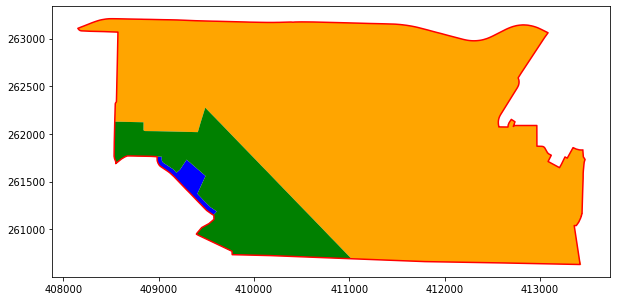

In [1444]:
ax = mt_shp[mt_shp['join_col'] =='049PCT 16'].boundary.plot(color="red",figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '049PCT 16'].plot(ax = ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '049PCT 16A'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '049PCT 16B'].plot(ax=ax, color='green')

<AxesSubplot:>

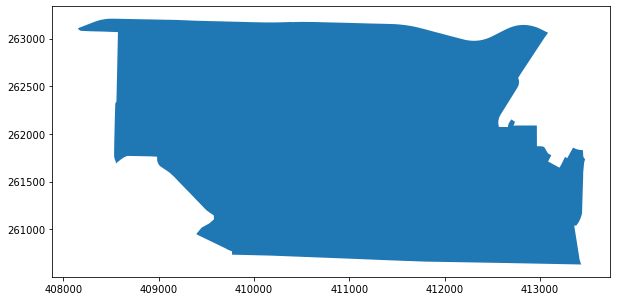

In [1445]:
#Merge precinct 16A, and 16B into 16
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 16"],vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 16A"],vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 16B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 16","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="049PCT 16A"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="049PCT 16B"]
vest_mt_16[vest_mt_16['join_col'] =='049PCT 16'].plot(figsize=(10,10))

<AxesSubplot:>

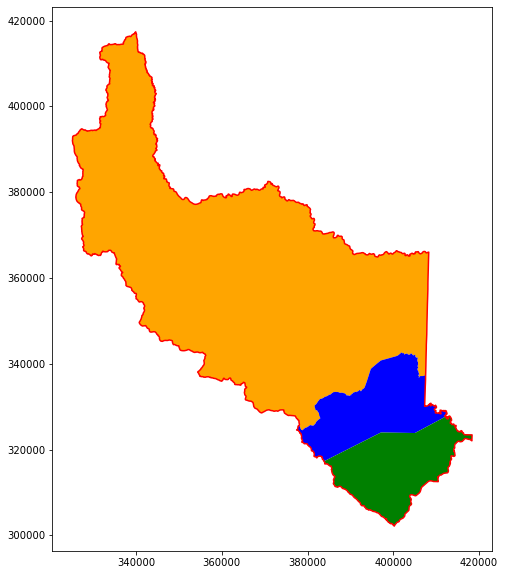

In [1446]:
ax = mt_shp[mt_shp['join_col'] =='049PCT 33'].boundary.plot(color="red",figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '049PCT 33'].plot(ax = ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '049PCT 33A'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '049PCT 33B'].plot(ax=ax, color='green')

<AxesSubplot:>

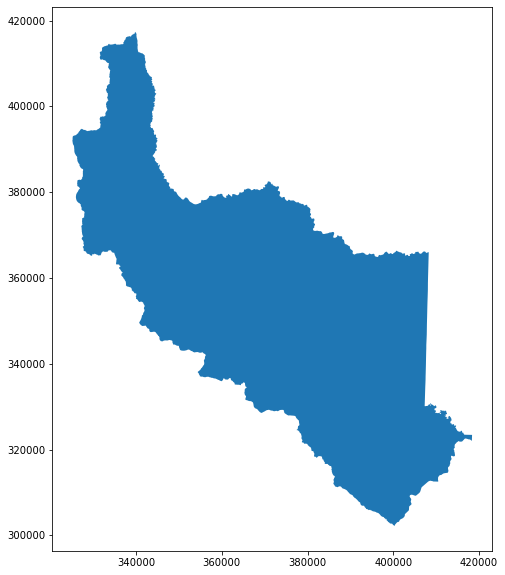

In [1447]:
#Merge precinct 33A, and 33B into 33
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 33"],vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 33A"],vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 33B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="049PCT 33","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="049PCT 33A"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="049PCT 33B"]
vest_mt_16[vest_mt_16['join_col'] =='049PCT 33'].plot(figsize=(10,10))

<AxesSubplot:>

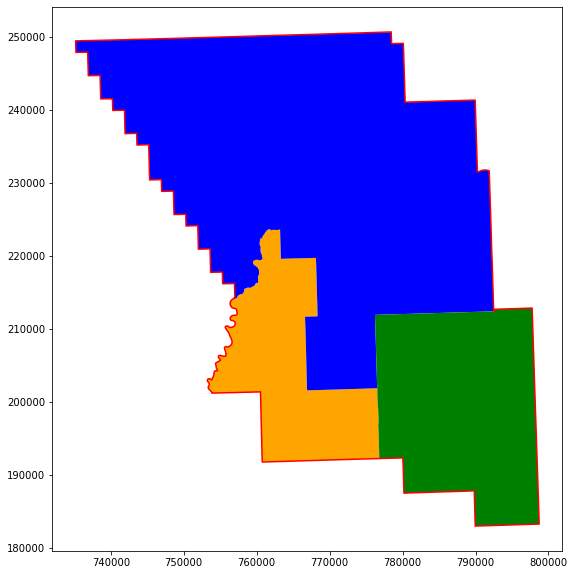

In [1448]:
ax = mt_shp[mt_shp['join_col'] =='103Precinct 1'].boundary.plot(color="red",figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT # 3'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT # 4'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '103PRECINCT # 6'].plot(ax=ax, color='green')

<AxesSubplot:>

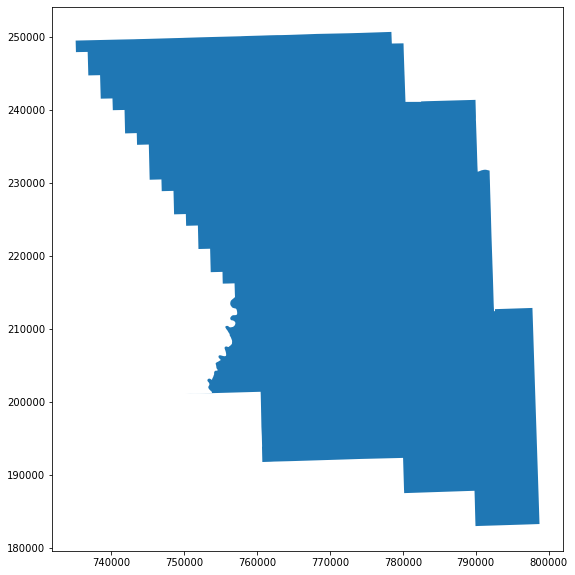

In [1449]:
#Merge precinct 3, 4, and 6 into 1
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT # 3"],vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT # 4"],vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT # 6"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="103PRECINCT # 3","join_col"]='103Precinct 1'
vest_mt_16.loc[vest_mt_16["join_col"]=="103Precinct 1","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="103PRECINCT # 4"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="103PRECINCT # 6"]
vest_mt_16[vest_mt_16['join_col'] =='103Precinct 1'].plot(figsize=(10,10))

> The following counties used 2016 precinct maps sourced from the respective county governments instead: Fallon, Phillips, Valley. 

Found these maps for Fallon county here that are PDFs but we can use to compare: 
https://www.falloncounty.net/Elections/Download_Map.pdf. No shapefiles available.

Maps for Phillips and Valley counties were not found and emails were not returned as of(6/24/21)


<AxesSubplot:>

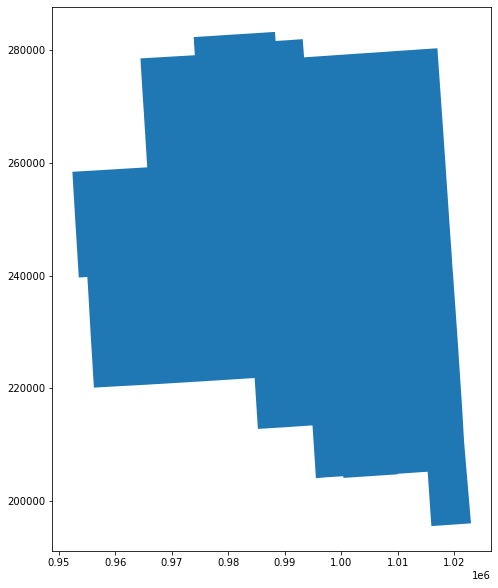

In [1450]:
mt_shp[mt_shp['join_col'] =='025PRECINCT 1'].plot(figsize=(10,10))

<AxesSubplot:>

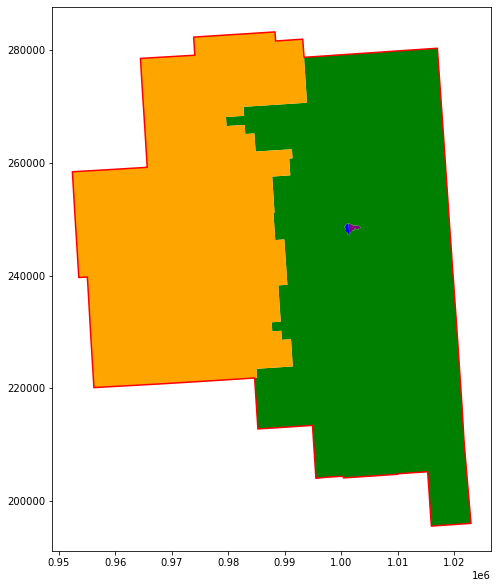

In [1451]:
ax = mt_shp[mt_shp['join_col'] =='025PRECINCT 1'].boundary.plot(color='red',figsize=(10,10)) 
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 1'].plot(ax=ax,color='purple')
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 2'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 3'].plot(ax=ax, color='green')
vest_mt_16[vest_mt_16['join_col'] == '025PRECINCT 4'].plot(ax=ax, color='orange')

<AxesSubplot:>

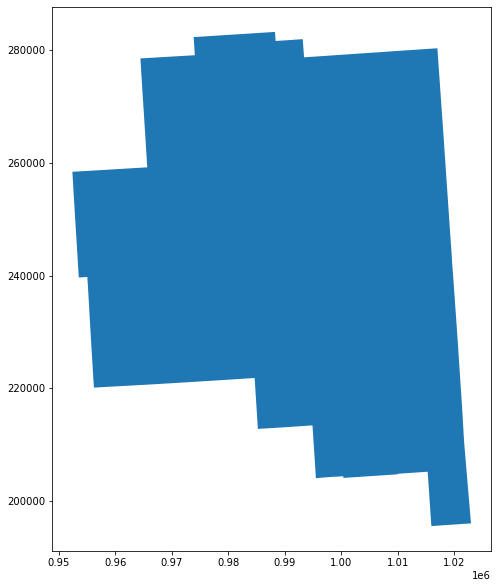

In [1452]:
#Merge Fallon precinct 1, 2, 3 and 4 into 1
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 1"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 2"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 3"],vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 4"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="025PRECINCT 1","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 2"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 3"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="025PRECINCT 4"]
vest_mt_16[vest_mt_16['join_col'] =='025PRECINCT 1'].plot(figsize=(10,10))

<AxesSubplot:>

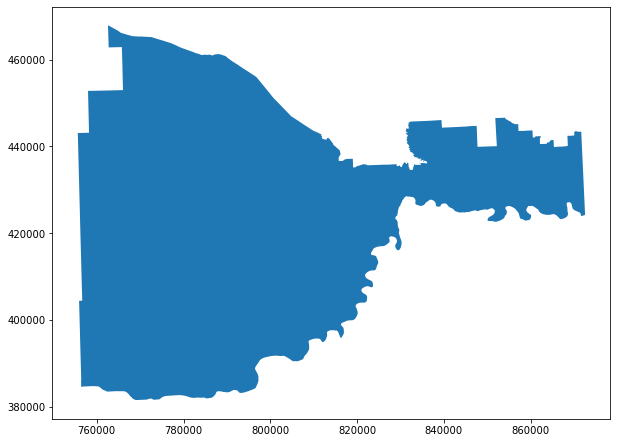

In [1453]:
mt_shp[mt_shp['join_col'] =='10531 FTP FRZ'].plot(figsize=(10,10))

<AxesSubplot:>

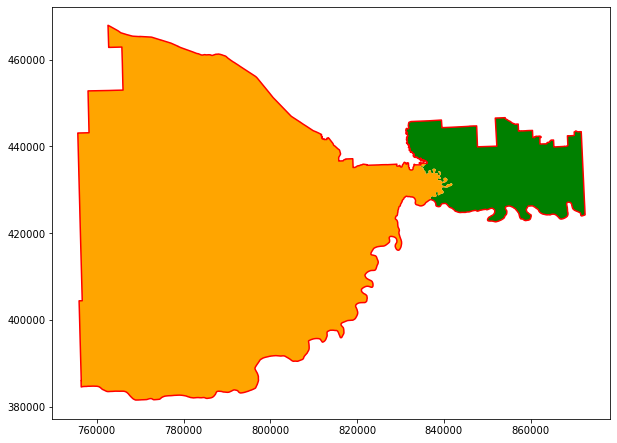

In [1454]:
ax = mt_shp[mt_shp['join_col'] =='10531 FTP FRZ'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '1052-FRAZER'].plot(ax=ax,color='green')
vest_mt_16[vest_mt_16['join_col'] == '1051-FORT PECK'].plot(ax=ax, color='orange')

<AxesSubplot:>

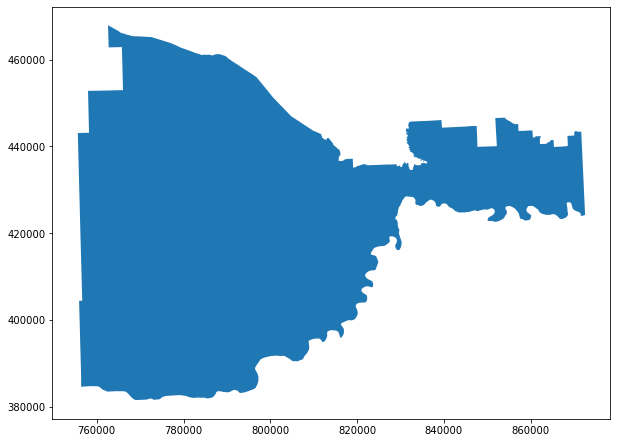

In [1455]:
#Merge precinct FRAZER and FORT PECK into 31 FTP FRZ
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="1052-FRAZER"],vest_mt_16.loc[vest_mt_16["join_col"]=="1051-FORT PECK"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="1052-FRAZER","join_col"]='10531 FTP FRZ'
vest_mt_16.loc[vest_mt_16["join_col"]=="10531 FTP FRZ","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="1051-FORT PECK"]
vest_mt_16[vest_mt_16['join_col'] =='10531 FTP FRZ'].plot(figsize=(10,10))

<AxesSubplot:>

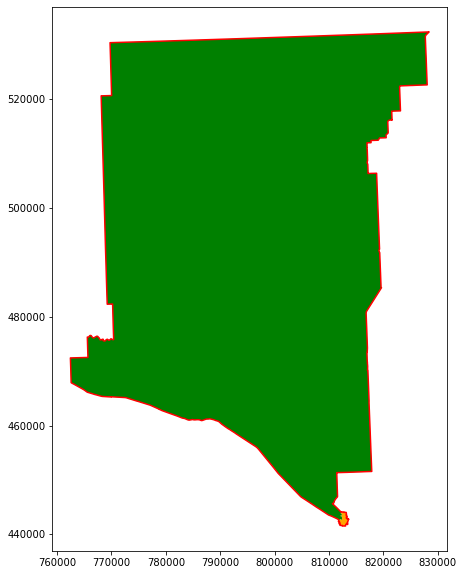

In [1456]:
ax = mt_shp[mt_shp['join_col'] =='10533 GLS HIN'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '1054-GLASGOW'].plot(ax=ax,color='orange')
vest_mt_16[vest_mt_16['join_col'] == '1053-HINSDALE'].plot(ax=ax, color='green')

<AxesSubplot:>

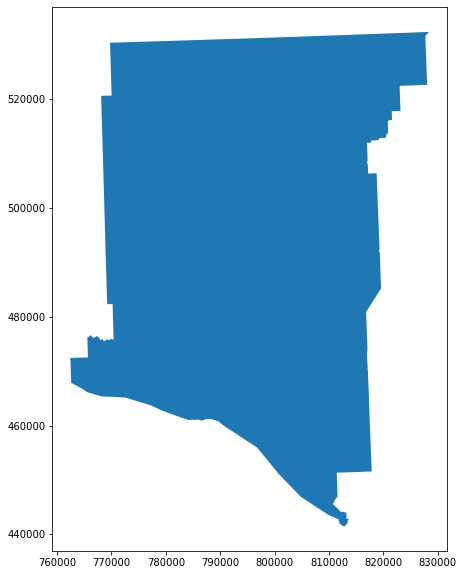

In [1457]:
#Merge precinct GLASGOW and HINSDALE into 33 GLS HIN
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="1054-GLASGOW"],vest_mt_16.loc[vest_mt_16["join_col"]=="1053-HINSDALE"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="1054-GLASGOW","join_col"]='10533 GLS HIN'
vest_mt_16.loc[vest_mt_16["join_col"]=="10533 GLS HIN","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="1053-HINSDALE"]
vest_mt_16[vest_mt_16['join_col'] =='10533 GLS HIN'].plot(figsize=(10,10))

<AxesSubplot:>

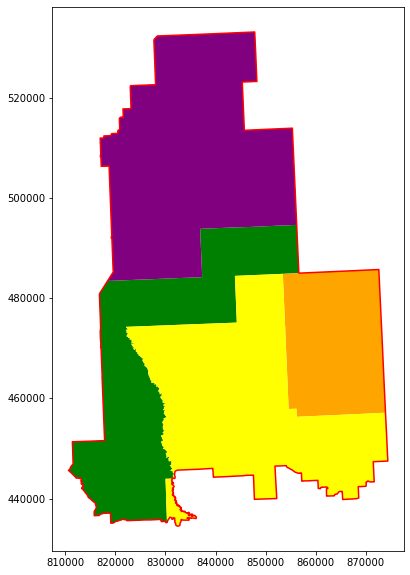

In [1458]:
ax = mt_shp[mt_shp['join_col'] =='10534 LUS OPH NAS GNE'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '1055-GLASGOW NE'].plot(ax=ax,color='green')
vest_mt_16[vest_mt_16['join_col'] == '1057-LUSTRE'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '1056-NASHUA'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '1058-OPHEIM'].plot(ax=ax, color='purple')

<AxesSubplot:>

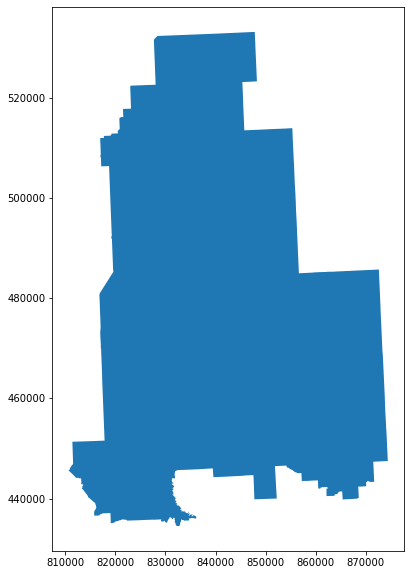

In [1459]:
#Merge precinct GLASGOW NORTHEAST, LUSTRE, NASHUA, and OPHEIM into 34 LUS OPH NAS GNE
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="1055-GLASGOW NE"],vest_mt_16.loc[vest_mt_16["join_col"]=="1057-LUSTRE"],vest_mt_16.loc[vest_mt_16["join_col"]=="1056-NASHUA"],vest_mt_16.loc[vest_mt_16["join_col"]=="1058-OPHEIM"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="1055-GLASGOW NE","join_col"]='10534 LUS OPH NAS GNE'
vest_mt_16.loc[vest_mt_16["join_col"]=="10534 LUS OPH NAS GNE","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="1057-LUSTRE"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="1056-NASHUA"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="1058-OPHEIM"]
vest_mt_16[vest_mt_16['join_col'] =='10534 LUS OPH NAS GNE'].plot(figsize=(10,10))

<AxesSubplot:>

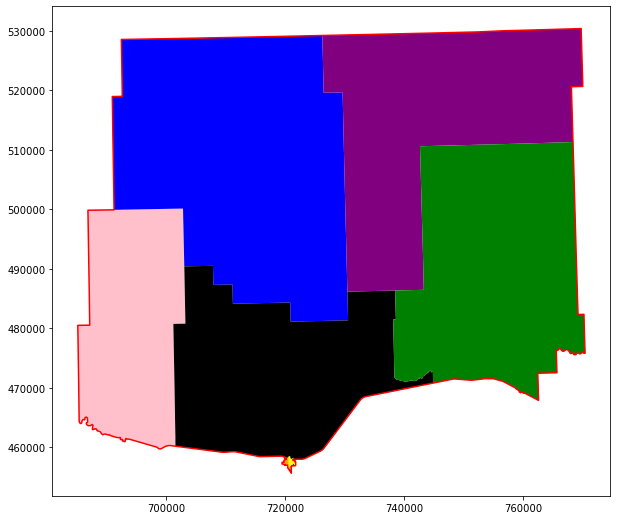

In [1460]:
ax = mt_shp[mt_shp['join_col'] =='071PCT 11N - PHILLIPS - 33/17'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '071PCT 2-N - DODSON NORTH - 33/17'].plot(ax=ax,color='pink')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 7 - LORING - 33/17'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 9-1 - MALTA CITY - 33/17'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 9-2 - MALTA CITY - 33/17'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 12-N - MALTA NORTH - 33/17'].plot(ax=ax, color='black')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 16 - WHITEWATER - 33/17'].plot(ax=ax, color='purple')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 8-N - SACO NORTH - 33/17'].plot(ax=ax, color='green')

<AxesSubplot:>

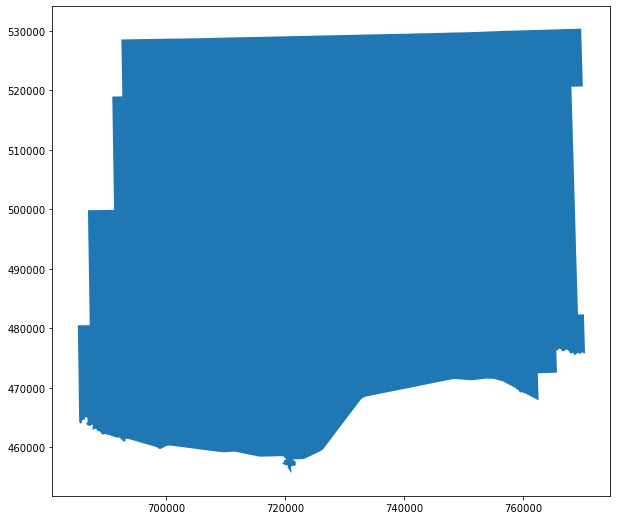

In [1461]:
#Merge precinct 2N DODSON NORTH, 7 LORING, 9-1 MALTA CITY WARD 1, 9-2 MALTA CITY WARD 2, 12N MALTA COUNTRY NORTH, 16 WHITEWATER, and 8N SACO NORTH into PCT 11N - PHILLIPS - 33/17
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 2-N - DODSON NORTH - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 7 - LORING - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 9-1 - MALTA CITY - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 9-2 - MALTA CITY - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 12-N - MALTA NORTH - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 16 - WHITEWATER - 33/17"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 8-N - SACO NORTH - 33/17"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 2-N - DODSON NORTH - 33/17","join_col"]='071PCT 11N - PHILLIPS - 33/17'
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 11N - PHILLIPS - 33/17","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 7 - LORING - 33/17"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 9-1 - MALTA CITY - 33/17"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 9-2 - MALTA CITY - 33/17"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 12-N - MALTA NORTH - 33/17"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 16 - WHITEWATER - 33/17"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 8-N - SACO NORTH - 33/17"]
vest_mt_16[vest_mt_16['join_col'] =='071PCT 11N - PHILLIPS - 33/17'].plot(figsize=(10,10))

<AxesSubplot:>

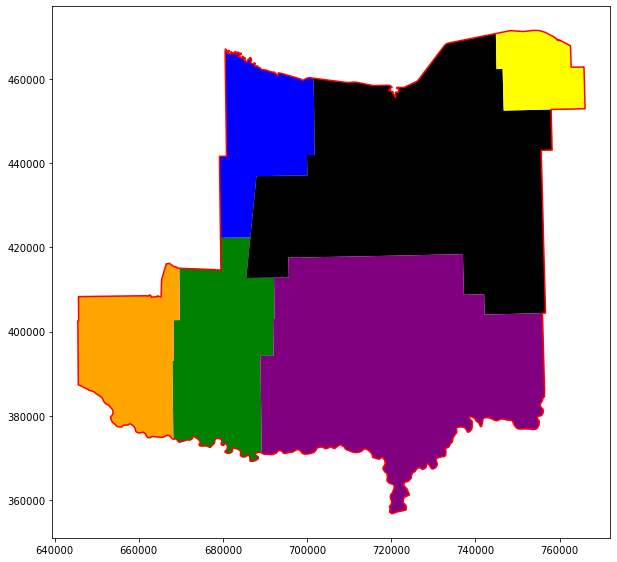

In [1462]:
ax = mt_shp[mt_shp['join_col'] =='071PCT 11S - PHILLIPS - 32/16'].boundary.plot(color='red',figsize=(10,10))
vest_mt_16[vest_mt_16['join_col'] == '071PCT 5 - ZORTMAN - 32/16'].plot(ax=ax,color='green')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 6 - LANDUSKY - 32/16'].plot(ax=ax, color='orange')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 2-S - DODSON SOUTH - 32/16'].plot(ax=ax, color='blue')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 12-S - MALTA SOUTH - 32/16'].plot(ax=ax, color='black')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 8-S - SACO SOUTH - 32/16'].plot(ax=ax, color='yellow')
vest_mt_16[vest_mt_16['join_col'] == '071PCT 11 - FIRST CREEK - 32/16'].plot(ax=ax, color='purple')

<AxesSubplot:>

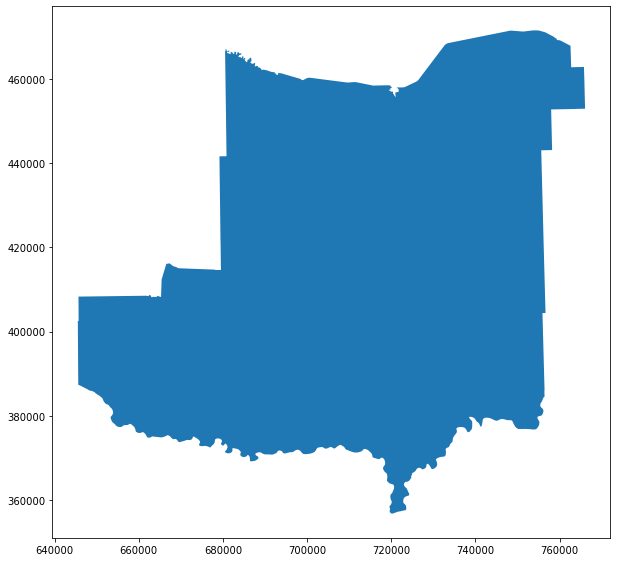

In [1463]:
#Merge precinct 5 ZORTMAN, 6 LANDUSKY, 2S DODSON SOUTH, 12S MALTA COUNTRY SOUTH, 8S SACO SOUTH, and 11 FIRST CREEK into PCT 11S - PHILLIPS - 32/16
prec2combine = [vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 5 - ZORTMAN - 32/16"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 6 - LANDUSKY - 32/16"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 2-S - DODSON SOUTH - 32/16"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 12-S - MALTA SOUTH - 32/16"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 8-S - SACO SOUTH - 32/16"],vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 11 - FIRST CREEK - 32/16"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 5 - ZORTMAN - 32/16","join_col"]='071PCT 11S - PHILLIPS - 32/16'
vest_mt_16.loc[vest_mt_16["join_col"]=="071PCT 11S - PHILLIPS - 32/16","geometry"]=new_fort.unary_union
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 6 - LANDUSKY - 32/16"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 2-S - DODSON SOUTH - 32/16"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 12-S - MALTA SOUTH - 32/16"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 8-S - SACO SOUTH - 32/16"]
vest_mt_16 = vest_mt_16[vest_mt_16["join_col"]!="071PCT 11 - FIRST CREEK - 32/16"]
vest_mt_16[vest_mt_16['join_col'] =='071PCT 11S - PHILLIPS - 32/16'].plot(figsize=(10,10))

## VEST has two precincts seperated when the SOS shapefile has them as one.
SOS election results has them seperated into two precincts.

> Precinct splits in Lake County were reversed based on the 2016 precinct shapefile from the county.

Found these maps here that are PDFs but we can use to compare: https://www.lakemt.gov/election/pdf/Lake%20County%20Precincts.pdf. No shapefiles available.

### Merge them in the SOS shapefile

<AxesSubplot:>

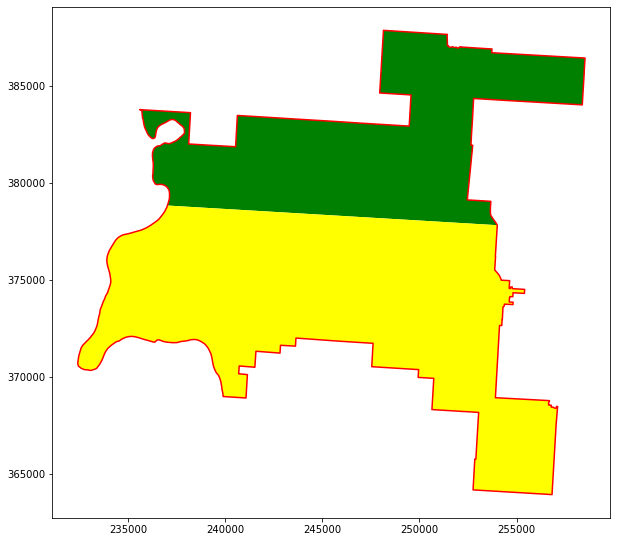

In [1464]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'RON 1 HD93'].boundary.plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'PAB 1_HD93'].plot(figsize=(10,10),ax=ax,color="green")
mt_shp[mt_shp['NAME'] == 'RON 1 HD93'].plot(figsize=(10,10),ax=ax,color="yellow")

<AxesSubplot:>

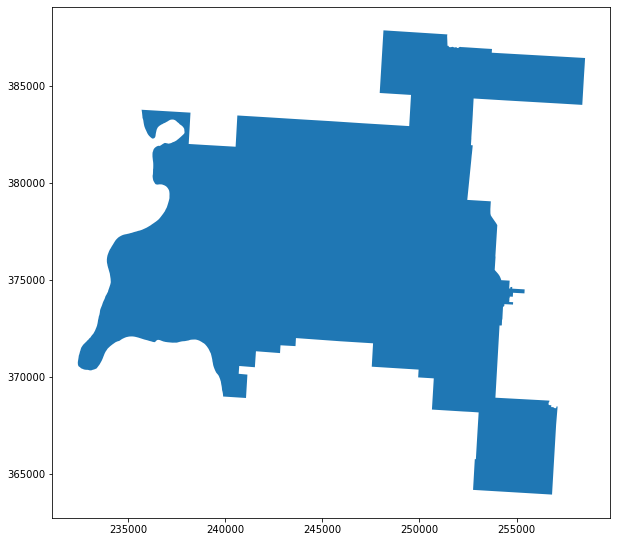

In [1465]:
#Merge precinct PAB 1 and RON 1 into RON 1
prec2combine = [mt_shp.loc[mt_shp["join_col"]=="047PAB 1_HD93"],mt_shp.loc[mt_shp["join_col"]=="047RON 1 HD93"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
mt_shp.loc[mt_shp["join_col"]=="047RON 1 HD93","geometry"]=new_fort.unary_union
mt_shp = mt_shp[mt_shp["join_col"]!="047PAB 1_HD93"]
mt_shp[mt_shp['join_col'] =='047RON 1 HD93'].plot(figsize=(10,10))

<AxesSubplot:>

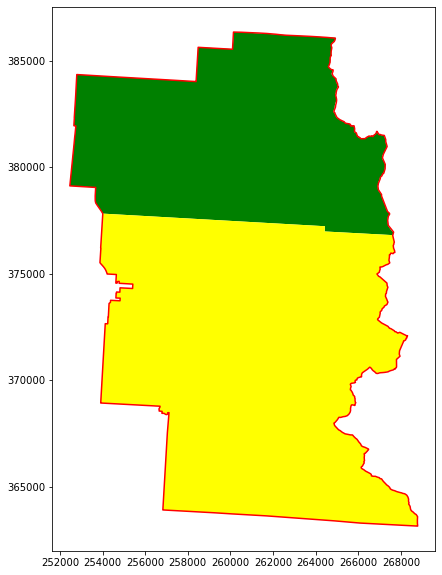

In [1466]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'RON 2 HD15'].boundary.plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'PAB 2_HD15'].plot(figsize=(10,10),ax=ax,color="green")
mt_shp[mt_shp['NAME'] == 'RON 2 HD15'].plot(figsize=(10,10),ax=ax,color="yellow")

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:>

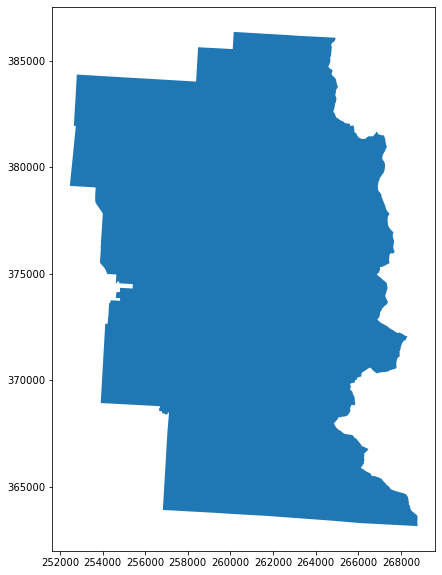

In [1467]:
#Merge precinct PAB 2 and RON 2 into RON 2
prec2combine = [mt_shp.loc[mt_shp["join_col"]=="047PAB 2_HD15"],mt_shp.loc[mt_shp["join_col"]=="047RON 2 HD15"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
mt_shp.loc[mt_shp["join_col"]=="047RON 2 HD15","geometry"]=new_fort.unary_union
mt_shp = mt_shp[mt_shp["join_col"]!="047PAB 2_HD15"]
mt_shp[mt_shp['join_col'] =='047RON 2 HD15'].plot(figsize=(10,10))

**Add names for zero vote precincts for merge**

In [1468]:
#Add names to join_col for zero vote precincts
vest_mt_16.at[389,'join_col'] = 'FLATHEAD-1'
vest_mt_16.at[390,'join_col'] = 'FLATHEAD-2'
vest_mt_16.at[682,'join_col'] = 'LAKE-1'

In [1469]:
mt_shp.at[437,'join_col'] = 'FLATHEAD-1'
mt_shp.at[438,'join_col'] = 'LAKE-1'
mt_shp.at[439,'join_col'] = 'FLATHEAD-2'

## **Final Merge**

In [1470]:
final_merge = pd.merge(mt_shp,vest_mt_16,how="outer",on="join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          664
left_only       0
right_only      0
Name: final_merge, dtype: int64

# **Validate Geometry**

In [1471]:
print(final_merge.columns)

Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH',
       'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN', 'G16HALDJUN', 'G16HALLBRE',
       'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN', 'G16ATGRFOX', 'G16ATGDJEN',
       'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO', 'G16AUDRROS', 'G16AUDDLAS',
       'G16SPIRARN', 'G16SPIDROM', 'geometry_y', 'final_merge'],
      dtype='object')


In [1472]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    632
True      32
dtype: int64


1) For Carter - PRECINCT #1 ALZADA difference in area is 0.10173848064848712
2) For Garfield - PRECINCT 01 difference in area is 0.20917505437514466
3) For Treasure - Precinct 1 difference in area is 0.26515436623529864
4) For Golden Valley - RYEGATE difference in area is 0.7463098176672933
5) For Golden Valley - LAVINA difference in area is 0.5339707751821665
6) For Daniels - PRECINCT #2 difference in area is 0.598768562017123
7) For Sanders - 3-TROUT CREEK-HD13 difference in area is 0.11690597506341056
8) For Daniels - PRECINCT #3 difference in area is 1.1446534156013435
9) For Wheatland - PRECINCT 3 difference in area is 0.4668704769169927
10) For Sweet Grass - PRECINCT 3 difference in area is 0.8519442719450299
11) For Beaverhead - PRECINCT 04 difference in area is 0.23138583339645355
12) For Sweet Grass - PRECINCT 4 difference in area is 0.3708095171162503
13) For Prairie - PRECINCT NO. 4 difference in area is 0.4879000269396799
14) For Powder River - PRECINCT04 difference in area

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For Garfield - PRECINCT 07 difference in area is 0.2725025489278113
23) For Musselshell - PRECINCT 7 difference in area is 0.13209372082656248
24) For Rosebud - PRECINCT 7 difference in area is 0.31508017323668797
25) For Glacier - PCT 08 difference in area is 0.156885169893103
26) For Custer - SHEFFIELD MOON difference in area is 0.14838756690948202
27) For Stillwater - RAPELJE PRECINCT 9 difference in area is 0.19838520005277924
28) For Custer - S-H SCHOOL difference in area is 0.12303606403282971
29) For Stillwater - NYE PRECINCT 10 difference in area is 0.15433979264640915
30) For Big Horn - PRECINCT #10 difference in area is 0.25869857522042927
31) For Rosebud - PRECINCT 10 difference in area is 0.31732014484474697
32) For Rosebud - PRECINCT 11 difference in area is 0.11338342288349024
33) For Powder River - PRECINCT11 difference in area is 0.1553007899655654
34) For Custer - SPRING CREEK SCH difference in area is 0.11207436672244589
35) For Powder River - PRECINCT12 differenc

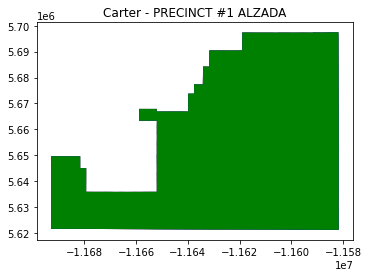

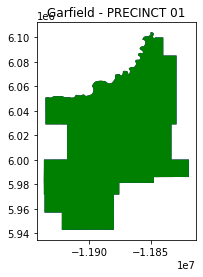

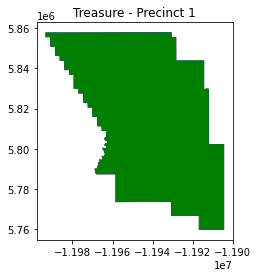

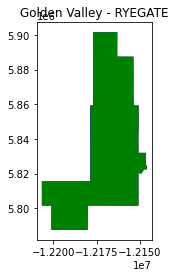

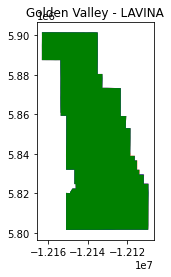

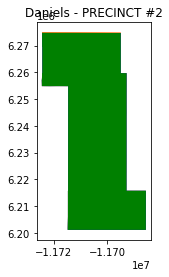

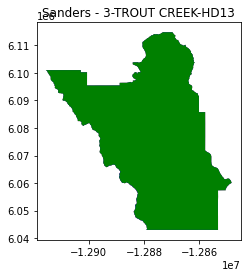

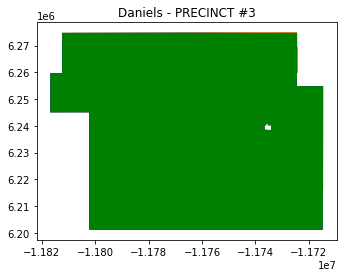

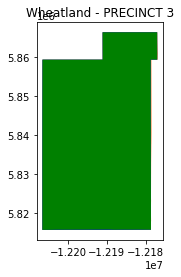

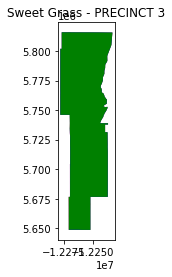

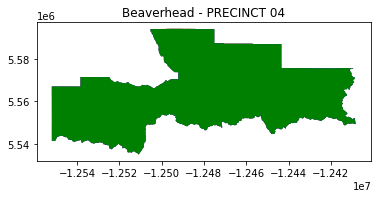

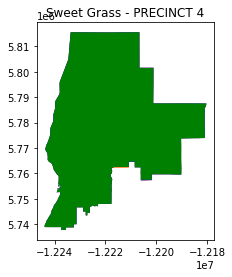

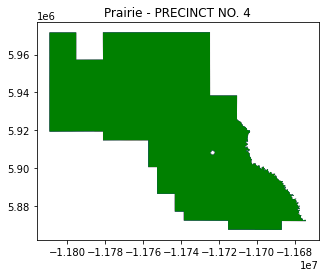

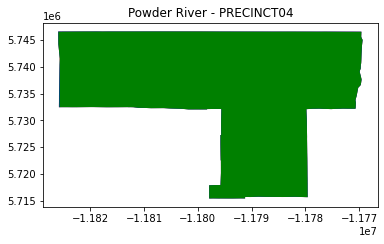

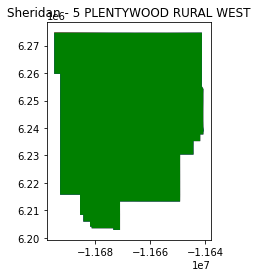

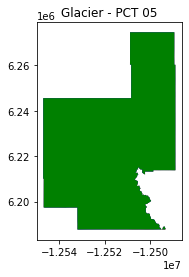

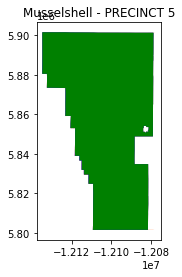

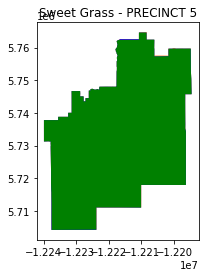

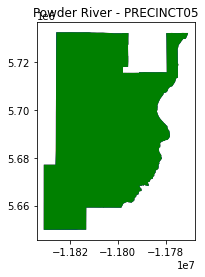

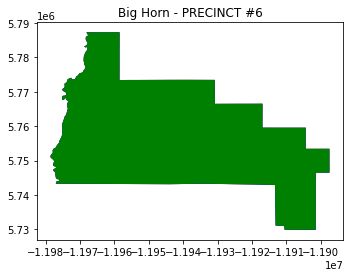

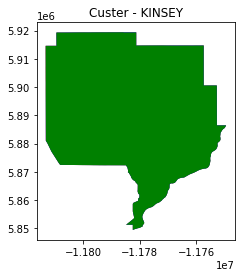

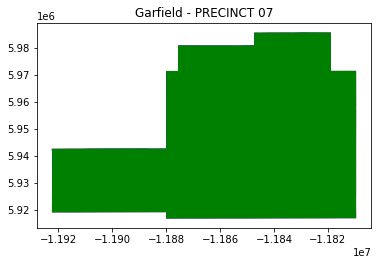

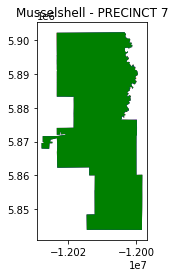

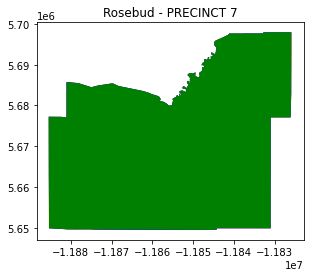

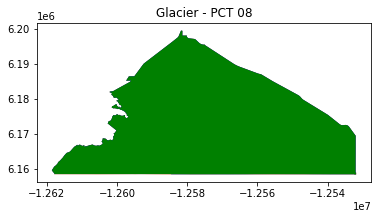

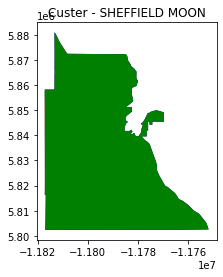

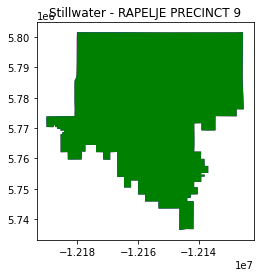

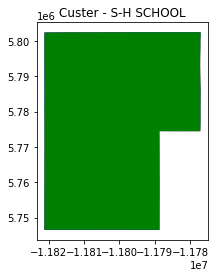

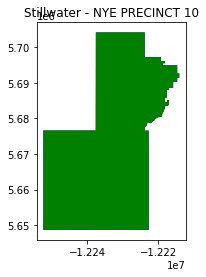

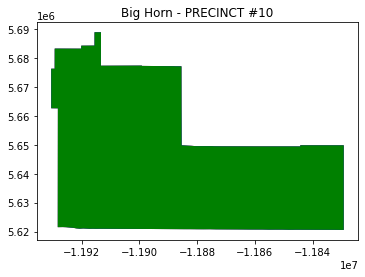

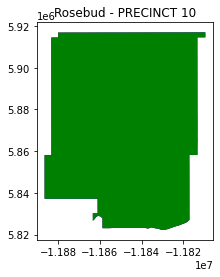

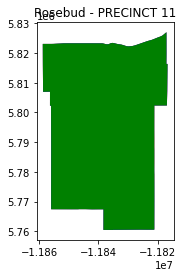

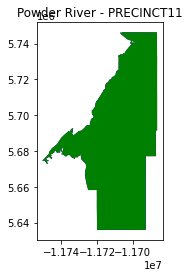

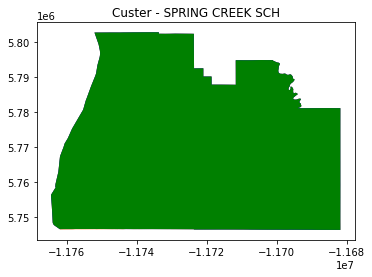

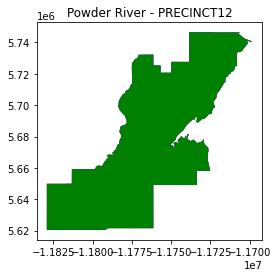

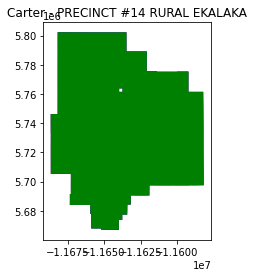

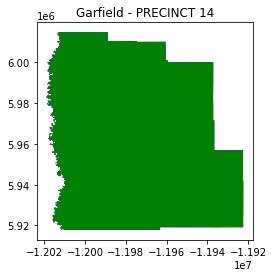

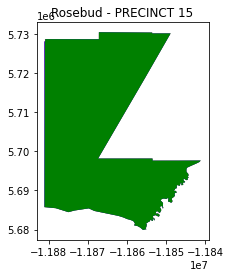

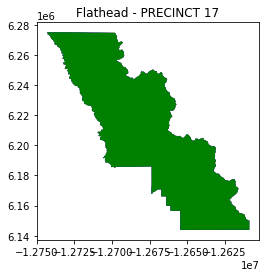

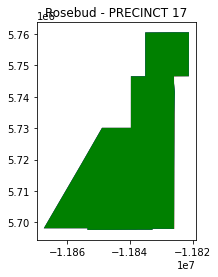

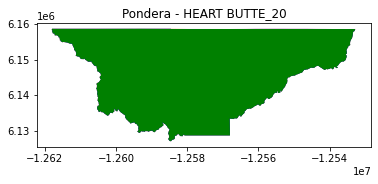

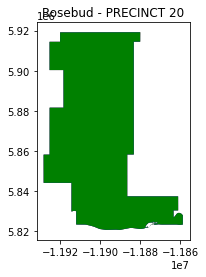

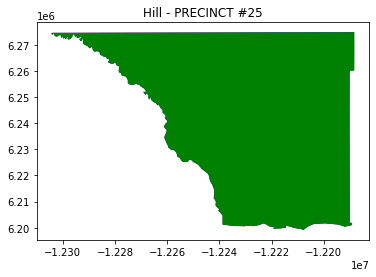

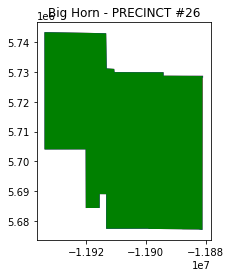

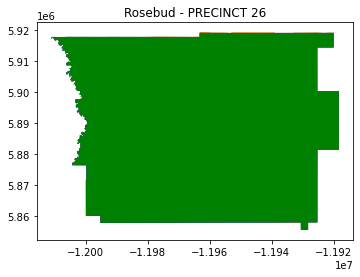

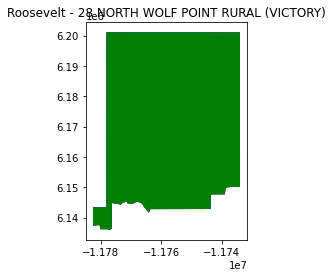

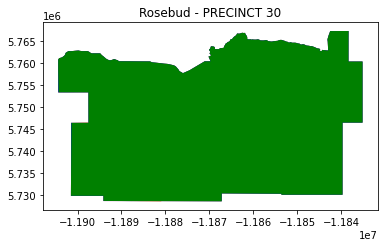

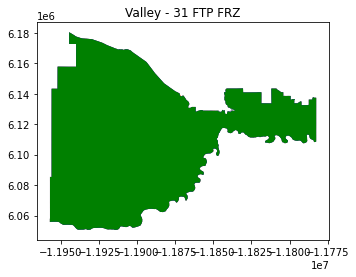

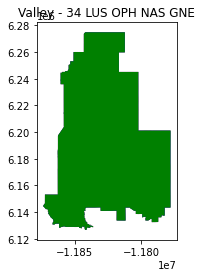

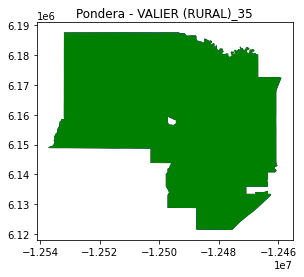

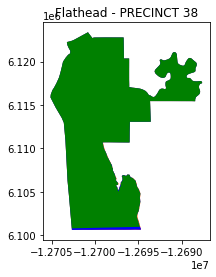

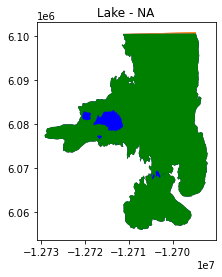

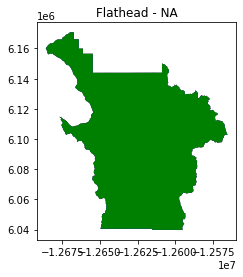

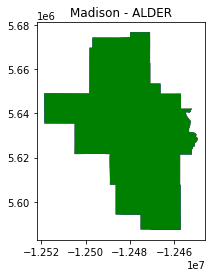

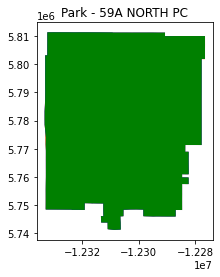

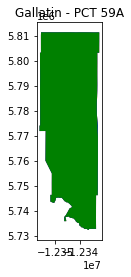

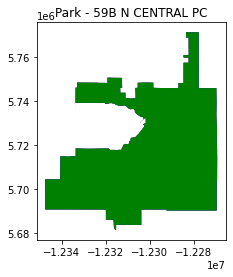

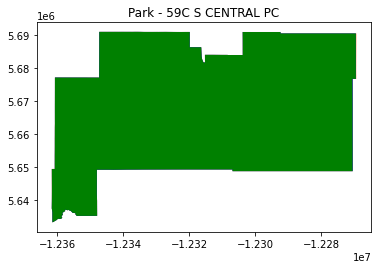

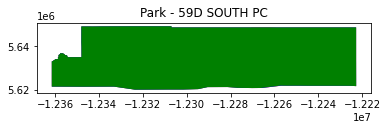

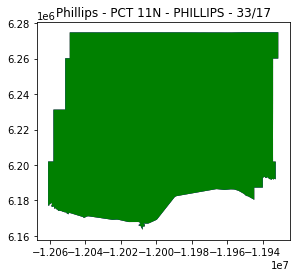

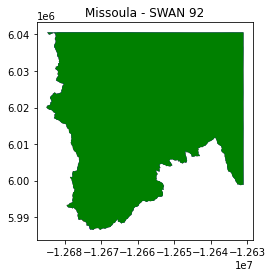

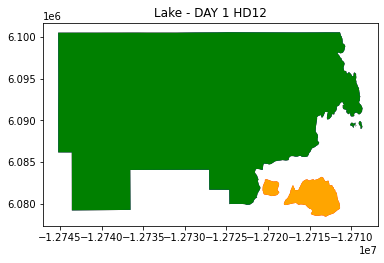

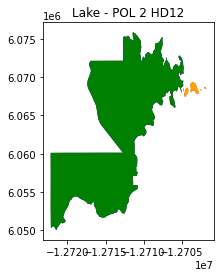

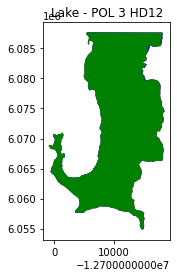

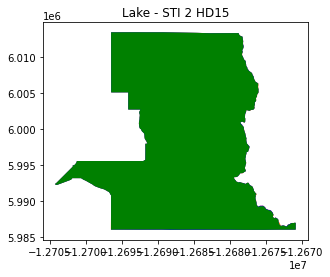

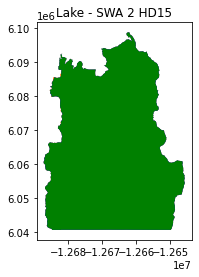

In [1473]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,1]
        county = source_geoms.iat[i,5]
        
        print(str(count)+") For " + county + ' - ' + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(county + ' - ' + name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(county + ' - ' + name)

In [1474]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(664, 1)
29 precincts w/ a difference of 0 km^2
569 precincts w/ a difference between 0 and .1 km^2
58 precincts w/ a difference between .1 and .5 km^2
5 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


## **Look into Flathead Lake differences**

### It appears that VEST assigned islands in Flathead lake to precincts "DAY 1 HD12" and "POL 2 HD12" which caused the largest discrepencies between the SOS shapefile and VEST's

<AxesSubplot:>

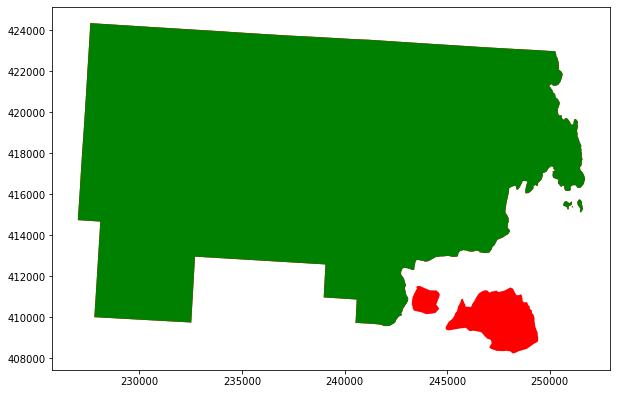

In [1475]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'DAY 1 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'DAY 1 HD12'].plot(figsize=(10,10),ax=ax,color="green")

<AxesSubplot:>

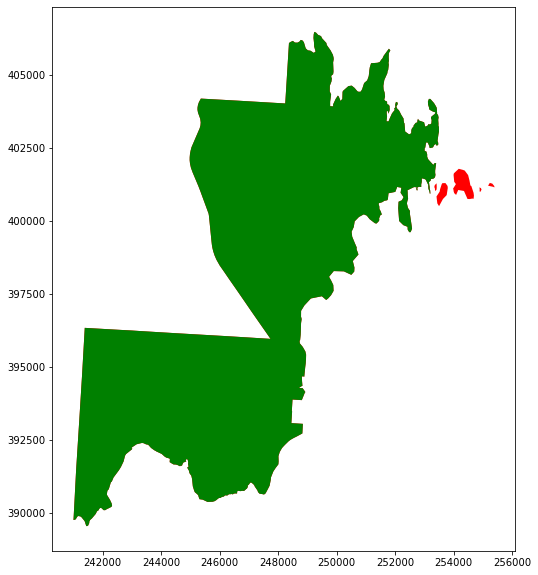

In [1476]:
ax = vest_mt_16[vest_mt_16['SOSPRECINC'] == 'POL 2 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'POL 2 HD12'].plot(figsize=(10,10),ax=ax,color="green")